# Model #1

In [44]:
# Import our dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [45]:
# Transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [46]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [47]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [48]:
# Validation for univariate data
from sklearn.metrics import mean_absolute_error
def walk_forward_validation(data, n_test):
    predictions = list()
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        testX, testy = test[i, :-1], test[i, -1]
        yhat = random_forest_forecast(history, testX)
        predictions.append(yhat)
        history.append(test[i])
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

In [49]:
# load the dataset
series = pd.read_csv('Resources/crypto_details_target.csv', header=0, index_col=0)

values = series.values

# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
data

MemoryError: Unable to allocate 2.68 GiB for an array with shape (91, 3948480) and data type object

# Model #2

In [1]:
# Import the dependency
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the dataset
crypto_details_df = pd.read_csv("Resources/crypto_details_target.csv")
crypto_details_df.head(10)

,Unnamed: 0,timestamp,date,Asset_ID,Asset_Name,Weight,Count,Volume,Open,High,Low,Close,VWAP,Target
0,0,1592697660,2020-06-21 00:01:00,1,Bitcoin,6.779922,504.0,15.768265,9364.227143,9378.100000,9359.9800,9366.225714,9365.439427,-0.000791
1,1,1592697660,2020-06-21 00:01:00,11,Monero,1.609438,6.0,23.654590,64.090000,64.110000,64.0900,64.110000,64.093652,-0.002652
2,2,1592697660,2020-06-21 00:01:00,5,EOS.IO,1.386294,435.0,80796.575643,2.540683,2.547300,2.5387,2.542350,2.542050,-0.002344
3,3,1592697660,2020-06-21 00:01:00,0,Binance Coin,4.304065,22.0,290.890000,16.068600,16.077500,16.0682,16.069700,16.070634,0.005875
4,4,1592697660,2020-06-21 00:01:00,9,Litecoin,2.397895,125.0,738.758489,43.651500,43.670000,43.6400,43.657500,43.656948,-0.000662
5,5,1592697660,2020-06-21 00:01:00,6,Ethereum,5.894403,424.0,1300.092998,229.055000,229.459933,228.9100,229.154989,229.136591,-0.000949
6,6,1592697720,2020-06-21 00:02:00,11,Monero,1.609438,12.0,63.852110,64.120000,64.120000,64.1000,64.110000,64.107327,-0.003044
7,7,1592697720,2020-06-21 00:02:00,9,Litecoin,2.397895,36.0,118.165684,43.661000,43.680000,43.6400,43.667200,43.664316,-0.000395
8,8,1592697720,2020-06-21 00:02:00,6,Ethereum,5.894403,289.0,239.642529,229.134596,229.437578,229.0100,229.161263,229.138053,-0.000677
9,9,1592697720,2020-06-21 00:02:00,0,Binance Coin,4.304065,46.0,481.530000,16.067300,16.072600,16.0648,16.066900,16.068496,0.003569


In [3]:
# Asset_ID = 1 for Bitcoin
btc = crypto_details_df[crypto_details_df["Asset_ID"]==1].set_index("timestamp")
btc.info(show_counts =True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658080 entries, 1592697660 to 1632182400
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  658080 non-null  int64  
 1   date        658080 non-null  object 
 2   Asset_ID    658080 non-null  int64  
 3   Asset_Name  658080 non-null  object 
 4   Weight      658080 non-null  float64
 5   Count       658080 non-null  float64
 6   Volume      658080 non-null  float64
 7   Open        658080 non-null  float64
 8   High        658080 non-null  float64
 9   Low         658080 non-null  float64
 10  Close       658080 non-null  float64
 11  VWAP        658080 non-null  float64
 12  Target      658080 non-null  float64
dtypes: float64(9), int64(2), object(2)
memory usage: 70.3+ MB


In [4]:
# Check the timestamp difference between consecutive rows to see if there is missing data.
(btc.index[1:]-btc.index[:-1]).value_counts().head()

60    658079
Name: timestamp, dtype: int64

## Overview of the Data

In [5]:
# Check the shape
print(f'Shape of Dataframe {btc.shape}')

Shape of Dataframe (658080, 13)


In [6]:
btc.describe()

,Unnamed: 0,Asset_ID,Weight,Count,Volume,Open,High,Low,Close,VWAP,Target
count,6.580800e+05,658080.0,6.580800e+05,658080.000000,658080.000000,658080.000000,658080.000000,658080.000000,658080.000000,658080.000000,658080.000000
mean,1.974240e+06,1.0,6.779922e+00,2098.830978,101.630036,31356.794270,31402.821670,31313.075779,31356.854642,31356.590653,-0.000009
std,1.139829e+06,0.0,2.166535e-11,2234.224683,146.515788,17177.712772,17200.478947,17153.715314,17177.707000,17177.527440,0.002192
min,0.000000e+00,1.0,6.779922e+00,1.000000,0.000500,8856.158750,8896.800000,8812.800000,8860.687291,8857.758372,-0.072556
25%,9.871210e+05,1.0,6.779922e+00,894.000000,38.181776,11824.261184,11838.000000,11813.937883,11824.223737,11824.385605,-0.000919
50%,1.974239e+06,1.0,6.779922e+00,1525.000000,63.630681,33533.012381,33585.148433,33490.000000,33533.639512,33534.756690,-0.000046
75%,2.961357e+06,1.0,6.779922e+00,2510.000000,111.647561,47089.410000,47146.000000,47030.437500,47089.755833,47088.192163,0.000825
max,3.948474e+06,1.0,6.779922e+00,87478.000000,5990.868930,64805.943750,64900.000000,64670.530000,64808.537275,64799.822215,0.089280


Text(0, 0.5, 'Close Price')

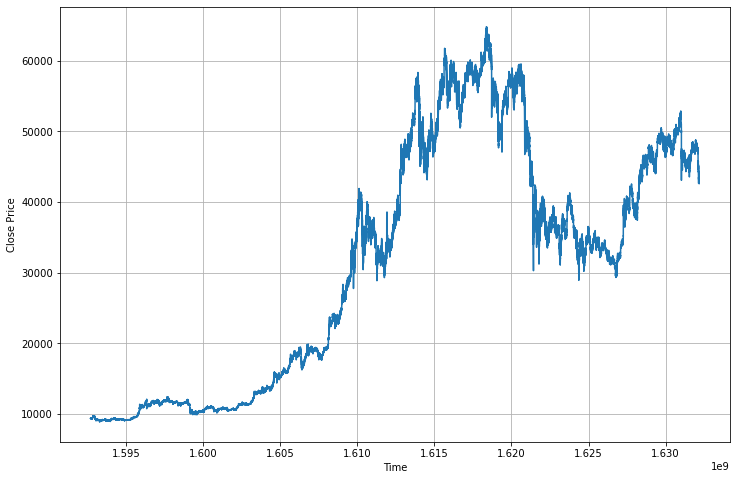

In [43]:
btc['Close'].plot(grid=True, figsize=(12,8))
plt.xlabel('Time')
plt.ylabel('Close Price')

In [41]:
# Candlestick chart
btc = crypto_details_df[crypto_details_df["Asset_ID"]==1].set_index("timestamp") # Asset_ID = 1 for Bitcoin
btc_mini = btc.iloc[-200:] # Select recent data rows

import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=btc_mini.index, open=btc_mini['Open'], high=btc_mini['High'], low=btc_mini['Low'], close=btc_mini['Close'])])
fig.show()

## Exploratory Data Analysis

array([[<AxesSubplot:title={'center':'Open'}>,
        <AxesSubplot:title={'center':'High'}>],
       [<AxesSubplot:title={'center':'Low'}>,
        <AxesSubplot:title={'center':'Close'}>],
       [<AxesSubplot:title={'center':'VWAP'}>,
        <AxesSubplot:title={'center':'Target'}>]], dtype=object)

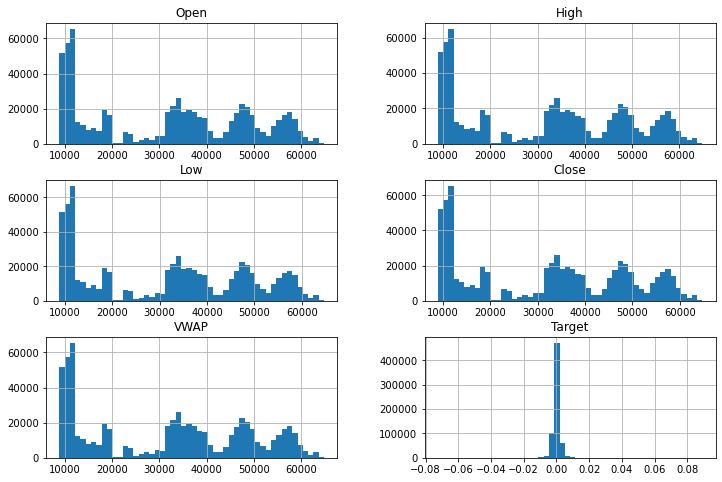

In [8]:
# Distribution of Open and Close prices, the Highest and Lowest prices
btc_eda=btc.drop(['Unnamed: 0','date','Asset_ID','Asset_Name','Weight','Count','Volume'],axis=1)
btc_eda.hist(bins=50,figsize=(12,8))

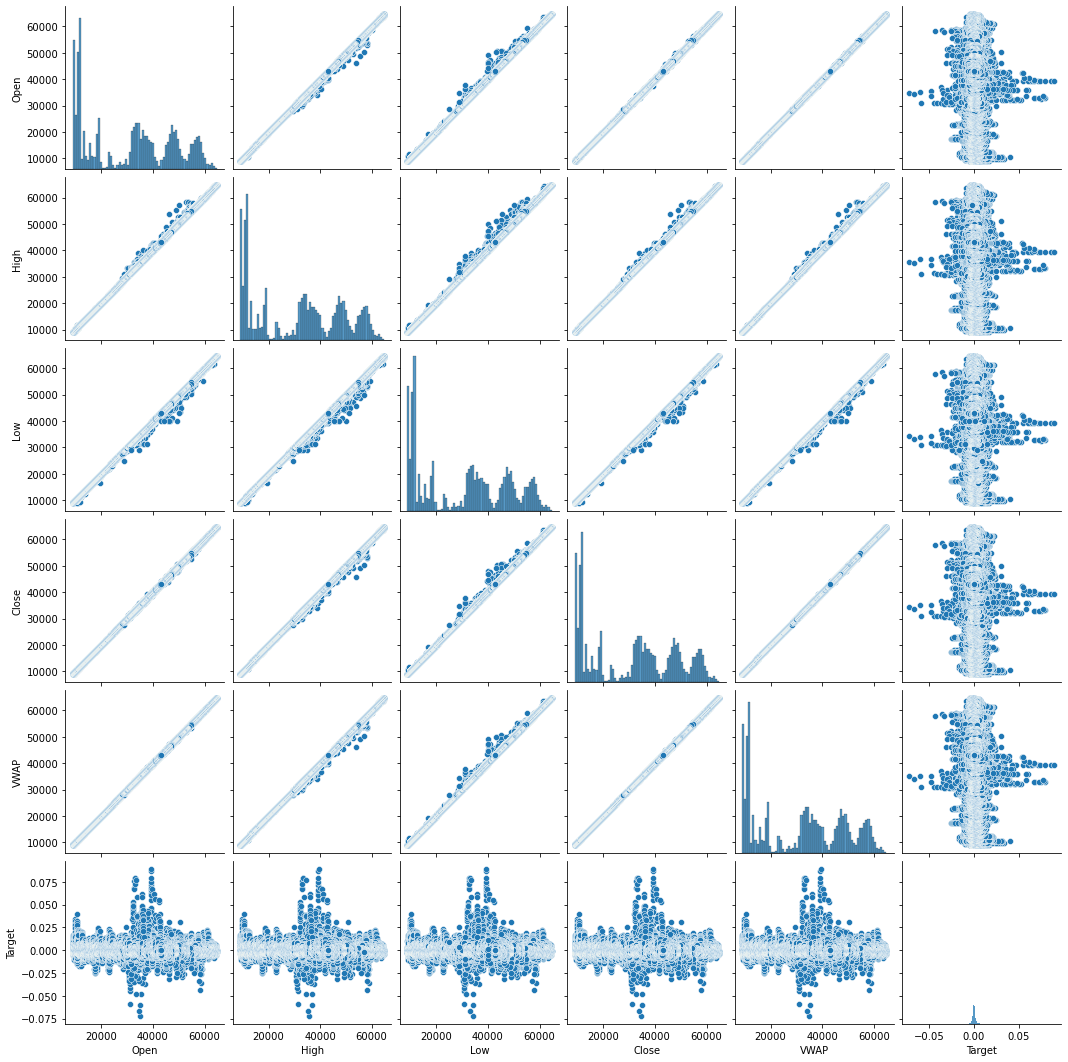

In [9]:
# a univariate distribution plot is drawn to show the marginal distribution of the data in each column.
sns.pairplot(data=btc_eda)

## Correlation

<AxesSubplot:>

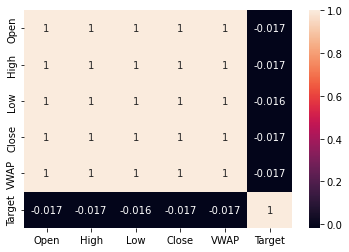

In [10]:
corr= btc_eda.corr()
sns.heatmap(corr,annot=True)

## Preprocessing the Data

In [14]:
# Scaling the data
scaler = StandardScaler()
scaler.fit(btc_eda.drop(['Target'],axis=1))

StandardScaler()

In [15]:
# Define the features set.
X=np.array(scaler.transform(btc_eda.drop(['Target'],axis=1)))

In [16]:
# Define the target set.
y= np.array(btc_eda['Target'])

## Split the Data

In [17]:
# Splitting into Train and Test sets.
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [19]:
print(f'shape of X_train : {X_train.shape}\nshape of X_test : {X_test.shape}\nshape of y_train : {y_train.shape}\nshape of y_test : {y_test.shape}')

shape of X_train : (526464, 5)
shape of X_test : (131616, 5)
shape of y_train : (526464,)
shape of y_test : (131616,)


## Random Forest Regression

In [20]:
modelEns = RandomForestRegressor()
modelEns.fit(X_train,y_train)
Y_predEns = modelEns.predict(X_test)

In [21]:
print("MSE : ",mean_absolute_error(y_test, Y_predEns))
print("MAE : ",mean_squared_error(y_test,Y_predEns))
print("R2_Score: ",r2_score(y_test,Y_predEns))

MSE :  0.0014012184841727473
MAE :  5.013768507124221e-06
R2_Score:  -0.0405932607770616


In [25]:
btc_pred = pd.DataFrame({"Real Prediction":y_test,"Model Prediction":Y_predEns})
btc_pred.head(10)

,Real Prediction,Model Prediction
0,0.000049,-0.001758
1,-0.000119,-0.000625
2,0.000224,0.000348
3,-0.003773,-0.000251
4,0.000052,-0.000020
5,-0.000177,0.000611
6,-0.002617,-0.000645
7,-0.000318,-0.000727
8,0.000464,-0.000149
9,0.000324,-0.000847


<AxesSubplot:>

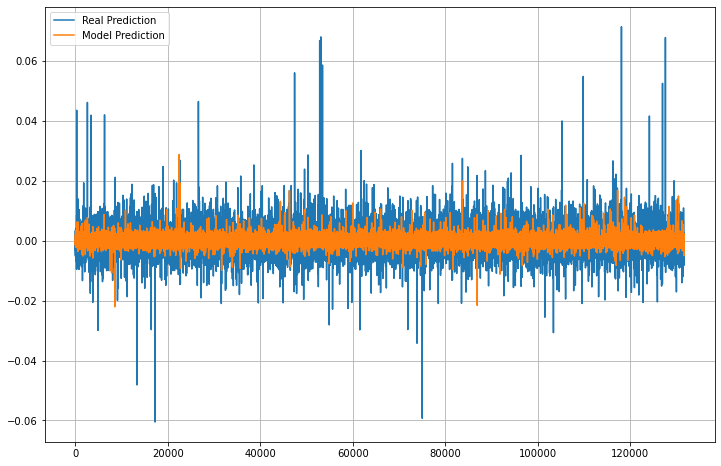

In [26]:
btc_pred.plot(grid=True, figsize=(12,8))

## Preprocessing the Data

In [27]:
# Scaling the data
scaler = StandardScaler()
scaler.fit(btc_eda.drop(['Close'],axis=1))

StandardScaler()

In [28]:
# Define the features set.
X=np.array(scaler.transform(btc_eda.drop(['Close'],axis=1)))

In [29]:
# Define the target set.
y= np.array(btc_eda['Close'])

## Split the Data

In [30]:
# Splitting into Train and Test sets.
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

print(f'shape of X_train : {X_train.shape}\nshape of X_test : {X_test.shape}\nshape of y_train : {y_train.shape}\nshape of y_test : {y_test.shape}')

shape of X_train : (526464, 5)
shape of X_test : (131616, 5)
shape of y_train : (526464,)
shape of y_test : (131616,)


## Random Forest Regression

In [31]:
modelEns = RandomForestRegressor()
modelEns.fit(X_train,y_train)
Y_predEns = modelEns.predict(X_test)

In [32]:
print("MSE : ",mean_absolute_error(y_test, Y_predEns))
print("MAE : ",mean_squared_error(y_test,Y_predEns))
print("R2_Score: ",r2_score(y_test,Y_predEns))

MSE :  10.130203472909873
MAE :  362.0882805332602
R2_Score:  0.9999987706418366


In [33]:
btc_pred2 = pd.DataFrame({"Real Prediction":y_test,"Model Prediction":Y_predEns})
btc_pred2.head(10)

,Real Prediction,Model Prediction
0,34809.205714,34814.195264
1,23230.781823,23229.459974
2,9109.742857,9108.733847
3,18069.033183,18066.427449
4,19045.843333,19048.330639
5,61050.320000,61066.186187
6,40423.785714,40426.524674
7,47105.628571,47085.050142
8,12793.430000,12793.890750
9,45633.197143,45656.627550


<AxesSubplot:>

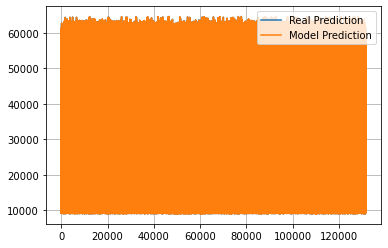

In [36]:
btc_pred2.plot(grid=True)